**Sources:**
- Github implementation [Denoising Diffusion Pytorch](https://github.com/lucidrains/denoising-diffusion-pytorch)
- Papers on Diffusion models ([Dhariwal, Nichol, 2021], [Ho et al., 2020] ect.)


## Import Packages and Set Seeds

In [14]:
import math
import copy
from pathlib import Path
from random import random
from functools import partial
from collections import namedtuple
from multiprocessing import cpu_count
import numpy as np

import torch
from torch import nn, einsum
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.utils as vutils
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import torchvision
from torchvision import transforms as T, utils

from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange
from PIL import Image
from tqdm import tqdm
from ema_pytorch import EMA

from accelerate import Accelerator
import matplotlib.pyplot as plt
import os

torch.backends.cudnn.benchmark = True
torch.manual_seed(4096)
if torch.cuda.is_available():
  torch.cuda.manual_seed(4096)

## Step 1: Forward process (Noise scheduler)




In [15]:
def linear_beta_schedule(timesteps):
    """
    linear schedule, proposed in original paper
    """
    scale = 1000 / timesteps
    beta_start = scale * 0.0001
    beta_end = scale * 0.02
    return torch.linspace(beta_start, beta_end, timesteps, dtype = torch.float64)

# e.g. from Nichol & Dhariwal’s “improved DDPM”:
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return betas.clamp(max=0.999)

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

Create dataset

In [16]:
class Dataset(Dataset):
    def __init__(
        self,
        folder,
        image_size
    ):
        self.folder = folder
        self.image_size = image_size
        self.paths = [p for p in Path(f'{folder}').glob(f'**/*.jpg')]
        #################################
        ## TODO: Data Augmentation ##
        #################################
        self.transform = T.Compose([
            T.Resize(image_size),
            T.ToTensor()
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        path = self.paths[index]
        img = Image.open(path)
        return self.transform(img)

## Step 2: The backward process = U-Net



Define some useful functions and U-Net

In [17]:
# normalization functions
def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

# iteration function
def cycle(dl):
    while True:
        for data in dl:
            yield data

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x
    
def Upsample(dim, dim_out=None):
    out_dim = dim_out if dim_out is not None else dim
    return nn.Sequential(
        nn.Upsample(scale_factor=2, mode='nearest'),
        nn.Conv2d(dim, out_dim, 3, padding=1)
    )

def Downsample(dim, dim_out=None):
    out_dim = dim_out if dim_out is not None else dim
    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1=2, p2=2),
        nn.Conv2d(dim * 4, out_dim, 1)
    )

class WeightStandardizedConv2d(nn.Conv2d):
    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        w = self.weight

        # compute per-out-channel mean & variance over (in_channels, kH, kW)
        mean = w.mean(dim=[1,2,3], keepdim=True)                   # shape [out,1,1,1]
        var  = w.var(dim= [1,2,3], unbiased=False, keepdim=True)   # shape [out,1,1,1]

        # weight-standardize
        w_norm = (w - mean) * (var + eps).rsqrt()

        return F.conv2d(
            x, w_norm, self.bias,
            stride=self.stride,
            padding=self.padding,
            dilation=self.dilation,
            groups=self.groups
        )

class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.g = nn.Parameter(torch.ones(1, dim, 1, 1))

    def forward(self, x):
        eps = 1e-5 if x.dtype == torch.float32 else 1e-3
        var = torch.var(x, dim=1, unbiased=False, keepdim=True)
        mean = torch.mean(x, dim=1, keepdim=True)
        return (x - mean) * (var + eps).rsqrt() * self.g

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = LayerNorm(dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)
    
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        return torch.cat((emb.sin(), emb.cos()), dim=-1)
    
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups=8):
        super().__init__()
        self.proj = WeightStandardizedConv2d(dim, dim_out, 3, padding=1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift=None):
        x = self.proj(x)
        x = self.norm(x)
        if scale_shift is not None:
            scale, shift = scale_shift
            x = x * (scale + 1) + shift
        return self.act(x)
    
class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = None
        if time_emb_dim is not None:
            self.mlp = nn.Sequential(
                nn.SiLU(),
                nn.Linear(time_emb_dim, dim_out * 2)
            )
        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        scale_shift = None
        if self.mlp is not None and time_emb is not None:
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim=1)
        h = self.block1(x, scale_shift=scale_shift)
        h = self.block2(h)
        return h + self.res_conv(x)
    
class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            LayerNorm(dim)
        )

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h=self.heads), qkv)
        q = q.softmax(dim=-2) * self.scale
        k = k.softmax(dim=-1)
        v = v / (h * w)
        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)
        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h=self.heads, x=h, y=w)
        return self.to_out(out)
    
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        resnet_block_groups=8
    ):
        super().__init__()
        self.channels = channels
        self.init_conv = nn.Conv2d(channels, dim, 7, padding=3)
        dims = [dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        time_dim = dim * 4

        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(dim),
            nn.Linear(dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        block_cls = partial(ResnetBlock, groups=resnet_block_groups, time_emb_dim=time_dim)
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind == (len(in_out) - 1)
            self.downs.append(nn.ModuleList([
                block_cls(dim_in, dim_in),
                block_cls(dim_in, dim_in),
                block_cls(dim_in, dim_in),
                Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding=1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_cls(mid_dim, mid_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, LinearAttention(mid_dim)))
        self.mid_block2 = block_cls(mid_dim, mid_dim)
        self.mid_block3 = block_cls(mid_dim, mid_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)
            self.ups.append(nn.ModuleList([
                block_cls(dim_out + dim_in, dim_out),
                block_cls(dim_out + dim_in, dim_out),
                block_cls(dim_out + dim_in, dim_out),
                Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                Upsample(dim_out, dim_in) if not is_last else nn.Conv2d(dim_out, dim_in, 3, padding=1)
            ]))

        self.final_res_block = block_cls(dim * 2, dim)
        self.final_conv = nn.Conv2d(dim, channels, 1)

    def forward(self, x, time):
        x = self.init_conv(x)
        residual = x.clone()
        t = self.time_mlp(time)
        h = []

        for block1, block2, block3, attn, down in self.downs:
            x = block1(x, t)
            h.append(x)
            x = block2(x, t)
            h.append(x)
            x = block3(x, t)
            x = attn(x)
            h.append(x)
            x = down(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)
        x = self.mid_attn(x)
        x = self.mid_block3(x, t)

        for block1, block2, block3, attn, up in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = torch.cat((x, h.pop()), dim=1)
            x = block2(x, t)
            x = torch.cat((x, h.pop()), dim=1)
            x = block3(x, t)
            x = attn(x)
            x = up(x)

        x = torch.cat((x, residual), dim=1)
        x = self.final_res_block(x, t)
        return self.final_conv(x)

## Step 3: The Diffusion Process



Define diffusion process, including generating noisy models, sample...


In [ ]:
class GaussianDiffusion(nn.Module):
    def __init__(
        self,
        model: nn.Module,
        image_size: int, 
        timesteps: int,
        beta_schedule: str = 'linear',
        auto_normalize: bool = True
    ):
        super().__init__()

        self.model = model
        self.channels = model.channels
        self.image_size = image_size
        self.num_timesteps = timesteps

        if beta_schedule == 'linear':
            betas = linear_beta_schedule(timesteps)
        elif beta_schedule == 'cosine':
            betas = cosine_beta_schedule(timesteps)
        else:
            raise ValueError(f'Unknown beta schedule: {beta_schedule}')
        
        alphas = 1.0 - betas
        alphas_cumprod = torch.cumprod(alphas, dim=0)
        alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)

        self.register_buffer('betas', betas.float())
        self.register_buffer('alphas_cumprod', alphas_cumprod.float())
        self.register_buffer('alphas_cumprod_prev', alphas_cumprod_prev.float())
        self.register_buffer('sqrt_alphas_cumprod', torch.sqrt(alphas_cumprod).float())
        self.register_buffer('sqrt_one_minus_alphas_cumprod', torch.sqrt(1 - alphas_cumprod).float())
        self.register_buffer('sqrt_recip_alphas_cumprod', torch.sqrt(1.0 / alphas_cumprod).float())
        self.register_buffer('sqrt_recipm1_alphas_cumprod', torch.sqrt(1.0 / alphas_cumprod - 1.0).float())

        # posterior q(x_{t-1} | x_t, x_0)
        posterior_variance = betas * (1 - alphas_cumprod_prev) / (1 - alphas_cumprod)
        self.register_buffer('posterior_variance', posterior_variance.float())
        self.register_buffer('posterior_log_variance_clipped', torch.log(posterior_variance.clamp(min=1e-20)).float())
        self.register_buffer('posterior_mean_coef1', (betas * torch.sqrt(alphas_cumprod_prev) / (1 - alphas_cumprod)).float())
        self.register_buffer('posterior_mean_coef2', ((1 - alphas_cumprod_prev) * torch.sqrt(alphas) / (1 - alphas_cumprod)).float())

        self.normalize = normalize_to_neg_one_to_one if auto_normalize else (lambda x: x)
        self.unnormalize = unnormalize_to_zero_to_one if auto_normalize else (lambda x: x)

    def predict_start_from_noise(self, x_t, t, noise):
        """Estimate x_0 from x_t and predicted noise"""
        return (
            extract(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t 
            - extract(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * noise
        )
    
    def q_posterior(self, x_start, x_t, t):
        """ Compute mean & variance of q(x_{t-1}) | x_t, x_0 """
        mean = (
            extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
            extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
        )
        var = extract(self.posterior_variance, t, x_t.shape)
        log_var = extract(self.posterior_log_variance_clipped, t, x_t.shape)
        return mean, var, log_var
    
    @torch.no_grad()
    def p_sample(self, x, t: int, clip_denoised: bool = True):
        """ One diffusion reverse step """
        b = x.shape[0]
        t_batch = torch.full((b,), t, device=x.device, dtype=torch.long)
        # model predicts noise
        pred_noise = self.model(x, t_batch)
        # recover x0; optionally clamp it
        x0 = self.predict_start_from_noise(x, t_batch, pred_noise)
        if clip_denoised:
            x0 = x0.clamp(-1.0, 1.0)

        # posterior mean & variance
        mean, _, log_var = self.q_posterior(x0, x, t_batch)
        noise = torch.randn_like(x) if t > 0 else 0.0
        return mean + torch.exp(0.5 * log_var) * noise

    @torch.no_grad()
    def p_sample_loop(self, shape, return_all_timesteps: bool = False):
        """ Starting from pure noise, run full reverse chain"""
        img = torch.randn(shape, device=self.betas.device)
        all_imgs = [img]
        for t in tqdm(reversed(range(self.num_timesteps)), desc='sampling'):
            img = self.p_sample(img, t)
            all_imgs.append(img)
        out = torch.stack(all_imgs, dim=1) if return_all_timesteps else img
        return self.unnormalize(out)
    
    @torch.no_grad()
    def p_sample_ddim(self, x, t, t_prev, eta=0.0, clip_denoised=True):
        """ One DDIM sampling step from x_t to x_{t_prev}"""
        b = x.shape[0]
        t_batch = torch.full((b, ), t, device=x.device, dtype=torch.long)
        # predict noise
        pred_noise = self.model(x, t_batch)
        # pred x0
        x0 = self.predict_start_from_noise(x, t_batch, pred_noise)
        if clip_denoised:
            x0 = x0.clamp(-1, 1)

        alpha_t = self.alphas_cumprod[t]
        alpha_prev = self.alphas_cumprod[t_prev] if t_prev >= 0 else torch.tensor(1.0, device=x.device)
        sqrt_alpha_t = alpha_t.sqrt()
        sqrt_alpha_prev = alpha_prev.sqrt()
        sigma_t = eta * ((1 - alpha_prev) / (1 - alpha_t) * (1 - alpha_t / alpha_prev)).sqrt()
        pred_dir = (1 - alpha_prev - sigma_t ** 2).sqrt() * pred_noise
        noise = sigma_t * torch.randn_like(x) if t_prev >= 0 else 0.0
        x_prev = sqrt_alpha_prev * x0 + pred_dir + noise

        return x_prev, x0
    
    @torch.no_grad()
    def ddim_sample_loop(self, shape, num_ddim_steps=50, eta=0.0, return_all_timesteps=False):
        """ Run the fuull DDIM sampling loop """
        device = self.betas.device
        img = torch.randn(shape, device=device)
        all_imgs = [img]

        # Create a custom timestep schedule
        ddim_timesteps = np.linspace(0, self.num_timesteps - 1, num_ddim_steps, dtype=int)

        for i in tqdm(range(num_ddim_steps - 1, -1, -1), desc='sampling'):
            t = ddim_timesteps[i]
            t_prev = ddim_timesteps[i - 1] if i > 0 else -1

            img, _ = self.p_sample_ddim(img, t, t_prev, eta=eta)
            all_imgs.append(img)
        
        out = torch.stack(all_imgs, dim=1) if return_all_timesteps else img
        return self.unnormalize(out)

    def sample(self, batch_size=16, use_ddim=False, num_ddim_steps=50, eta=0.0, return_all_timesteps=False):
        shape = (batch_size, self.channels, self.image_size, self.image_size)
        if use_ddim:
            return self.ddim_sample_loop(shape, num_ddim_steps=num_ddim_steps, eta=eta, return_all_timesteps=return_all_timesteps)
        else:
            return self.p_sample_loop(shape, return_all_timesteps=return_all_timesteps)
    
    def q_sample(self, x_start, t, noise=None):
        """ Forward noising process """
        if noise is None:
            noise = torch.randn_like(x_start)
        return (
            extract(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start + 
            extract(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise
        )
    
    def p_losses(self, x_start, t, noise=None):
        """ MSE loss between true noise and model's prediction """
        if noise is None:
            noise = torch.randn_like(x_start)
        x_noisy = self.q_sample(x_start, t, noise)
        pred_noise = self.model(x_noisy, t)
        loss = F.mse_loss(pred_noise, noise, reduction='none')
        loss = loss.mean(dim=list(range(1, loss.ndim))) # mean over c, h, w
        return loss.mean()
    
    def forward(self, img):
        """ Training entrypoint: sample random timesteps & return loss """
        b, c, h, w = img.shape
        assert h == self.image_size and w == self.image_size
        t = torch.randint(0, self.num_timesteps, (b, ), device=img.device)
        img = self.normalize(img)
        return self.p_losses(img, t)

Define Trainer: define the updating process

In [19]:
class Trainer:
    def __init__(
        self,
        diffusion_model: nn.Module,
        data_folder: str,
        batch_size: int = 16,
        lr: float = 1e-4,
        num_steps: int = 100000,
        grad_accum_steps: int = 1,
        ema_decay: float = 0.995,
        save_interval: int = 1000,
        num_samples: int = 25,
        results_folder: str = './results',
        use_ddim = False,
        num_ddim_steps=50,
        eta = 0.0
    ):
        # Accelerator
        self.accelerator = Accelerator(mixed_precision='no')
        self.device = self.accelerator.device

        # Training State
        self.batch_size       = batch_size
        self.grad_accum_steps = grad_accum_steps
        self.num_steps        = num_steps
        self.save_interval    = save_interval
        self.num_samples      = num_samples

        # model, optimizer, EMA
        self.model = diffusion_model.to(self.device)
        self.optimizer = Adam(self.model.parameters(), lr=lr)
        self.scheduler = CosineAnnealingLR(self.optimizer, T_max=self.num_steps, eta_min=1e-6)
        self.model, self.optimizer = self.accelerator.prepare(
            self.model, self.optimizer
        )
        
        # Use EMA on the raw model
        self.ema = EMA(self.accelerator.unwrap_model(self.model), beta=ema_decay)

        # Data
        ds = Dataset(data_folder, diffusion_model.image_size)
        dl = DataLoader(ds, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())
        self.dl = cycle(self.accelerator.prepare(dl))

        # checkpoints & samples
        self.results_folder = Path(results_folder)
        self.results_folder.mkdir(parents=True, exist_ok=True)
        self.step = 0
        self.use_ddim = use_ddim
        self.num_ddim_steps = num_ddim_steps
        self.eta = eta
    
    def save(self, milestone: int):
        """Save model, optimizer, EMA and step counter."""
        if not self.accelerator.is_main_process:
            return
        ckpt = self.results_folder / f'model-{milestone}.pt'
        data = {
            'step': self.step,
            'model': self.accelerator.get_state_dict(self.model),
            'optimizer': self.optimizer.state_dict(),
            'ema':       self.ema.state_dict(),
        }
        torch.save(data, ckpt)

    def load(self, ckpt_path: str):
        """Load all state (model, optimizer, EMA, step)."""
        data = torch.load(ckpt_path, map_location=self.device)
        raw_model = self.accelerator.unwrap_model(self.model)
        raw_model.load_state_dict(data['model'])
        self.optimizer.load_state_dict(data['optimizer'])
        self.ema.load_state_dict(data['ema'])
        self.step = data['step']

    def _sample_and_save(self, milestone: int):
        """Generate `num_samples` via EMA model and save grid."""
        self.ema.ema_model.eval()
        batches = num_to_groups(self.num_samples, self.batch_size)
        imgs = torch.cat([
            self.ema.ema_model.sample(batch_size=n, use_ddim=self.use_ddim, num_ddim_steps=self.num_ddim_steps, eta=self.eta) for n in batches
        ], dim=0)
        path = self.results_folder / f'sample-{milestone}.png'
        vutils.save_image(imgs, path, nrow=int(math.sqrt(self.num_samples)))

    def train(self):
        """Run the training loop with gradient accumulation, EMA updates, and periodic sampling."""
        pbar = tqdm(total=self.num_steps, initial=self.step, disable=not self.accelerator.is_main_process)
        while self.step < self.num_steps:
            total_loss = 0.0

            # gradient accumulation
            for _ in range(self.grad_accum_steps):
                batch = next(self.dl).to(self.device)
                with self.accelerator.autocast():
                    loss = self.model(batch) / self.grad_accum_steps
                total_loss += loss.item()
                self.accelerator.backward(loss)

            # optimizer step
            self.accelerator.clip_grad_norm_(self.model.parameters(), 1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()
            self.step += 1

            # EMA & sampling
            if self.accelerator.is_main_process:
                self.ema.update()
                if self.step % self.save_interval == 0:
                    milestone = self.step // self.save_interval
                    self._sample_and_save(milestone)
                    self.save(milestone)

            pbar.set_description(f'loss: {total_loss:.4f}')
            pbar.update(1)

        if self.accelerator.is_main_process:
            print('Training completed.')

    def inference(self, total: int = 1000, output_path: str = './submission'):
        """
        Generate `total` images using the same batch size as training
        (self.batch_size, e.g. 16), and save them to disk.
        """
        Path(output_path).mkdir(parents=True, exist_ok=True)
        count = 0
        batch_size = self.batch_size  # manually fixed at 16

        with torch.no_grad():
            while count < total:
                n = min(batch_size, total - count)

                # clear any leftover GPU memory
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

                # sample n images
                imgs = self.ema.ema_model.sample(batch_size=n, use_ddim=self.use_ddim, num_ddim_steps=self.num_ddim_steps, eta=self.eta)

                # move to CPU and save
                imgs = imgs.cpu()
                for img in imgs:
                    count += 1
                    vutils.save_image(img, f"{output_path}/{count}.jpg")

                # clean up 
                del imgs
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

        print("Inference completed.")            
                

# Training Hyper-parameters

In [20]:
train_data_path = './face_dataset'
IMG_SIZE = 64
batch_size = 8
train_num_steps = 10000
lr = 2e-4
grad_steps = 1
ema_decay = 0.9999

channels = 64
dim_mults = (1, 2, 4, 8)

timesteps = 1000
beta_schedule = 'cosine'

use_ddim = True
num_ddim_steps = 50
eta = 0.0

model = Unet(
    dim = channels,
    dim_mults = dim_mults
)

diffusion = GaussianDiffusion(
    model,
    image_size = IMG_SIZE,
    timesteps = timesteps,
    beta_schedule = beta_schedule
)

trainer = Trainer(
    diffusion,
    data_folder = train_data_path,
    batch_size = batch_size,
    lr = lr,
    num_steps = train_num_steps,
    grad_accum_steps = grad_steps,
    ema_decay = ema_decay,
    save_interval = timesteps,
    use_ddim=use_ddim,
    num_ddim_steps=num_ddim_steps,
    eta=eta,
)

trainer.train()

loss: 0.0575: 100%|██████████| 10000/10000 [29:38<00:00,  5.62it/s]

Training completed.


# Denoise

sampling: 1000it [00:34, 29.13it/s]


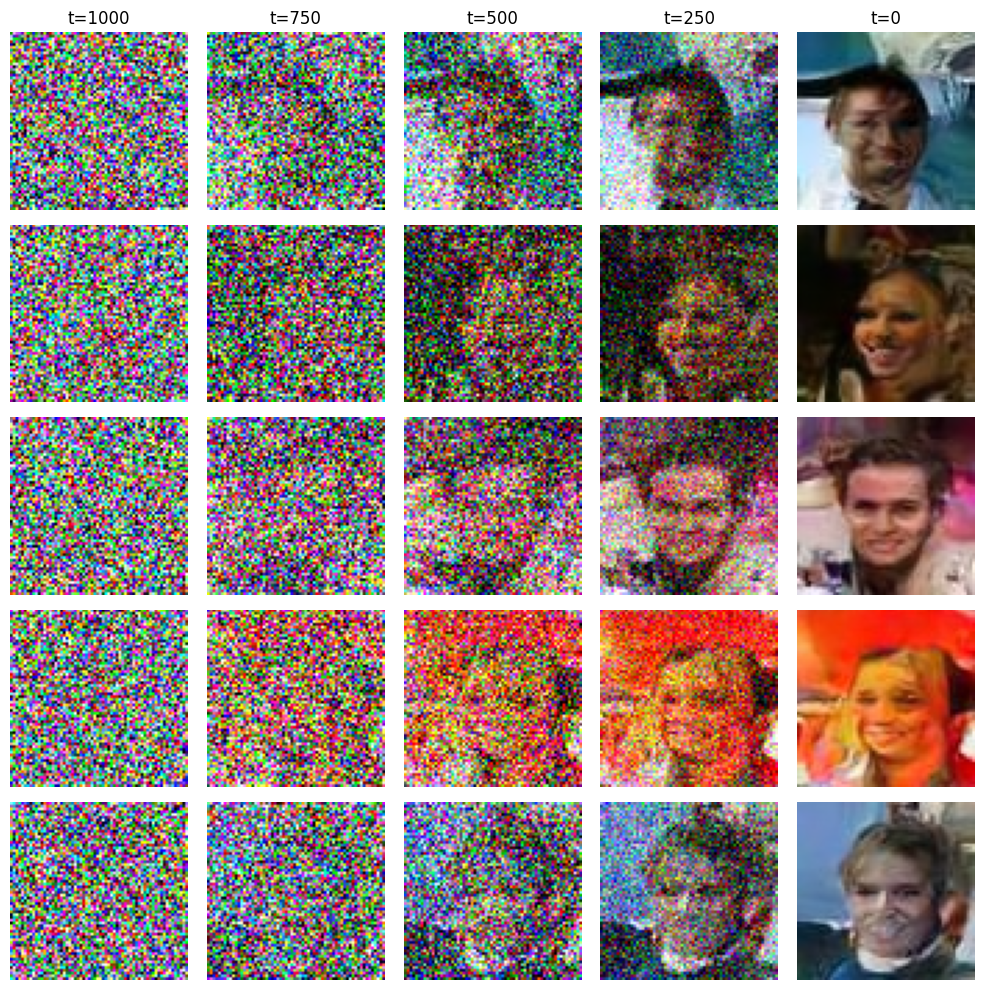

In [21]:

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 設定參數
num_images = 5
num_display_steps = 5  # 要顯示幾次（不等於幾步）！

# 將 diffusion 模型移到 GPU
diffusion = diffusion.to(device)
diffusion.eval()

# 取得所有 timestep 的生成結果（包括最初的噪聲）
samples = diffusion.sample(batch_size=num_images, return_all_timesteps=True)  # [B, T+1, C, H, W]

# 調整 shape 為 [T+1, B, C, H, W]
samples = samples.permute(1, 0, 2, 3, 4)

# 計算總步數，並選擇想要顯示的 step index
total_steps = samples.shape[0]

# 確保不會除以 0，並選取平均分佈的 step
num_display_steps = min(num_display_steps, total_steps)
step_indices = torch.linspace(0, total_steps - 1, steps=num_display_steps, dtype=torch.int).tolist()
step_indices = sorted(set(map(int, step_indices)))

# 畫圖
fig, axes = plt.subplots(num_images, len(step_indices), figsize=(len(step_indices)*2, num_images*2))

for i, step in enumerate(step_indices):
    imgs = samples[step].cpu()  # [B, C, H, W]

    for j in range(num_images):
        img = imgs[j]
        axes[j, i].imshow(img.permute(1, 2, 0).clamp(0, 1).numpy())
        axes[j, i].axis("off")
        if j == 0:
            axes[j, i].set_title(f"t={total_steps - step - 1}")

plt.tight_layout()
plt.show()



# Inference

In [22]:

ckpt = 'results/model-10.pt'
trainer.load(ckpt)
trainer.inference()


/tmp/ipykernel_636947/3300695660.py:68: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(ckpt_path, map_location=self.device)
sampling: 100%|██████████| 50/50

Inference completed.


In [23]:
%cd ./submission
!zip -r ../submission.zip .
%cd ..

/home/josh/Downloads/DL_HW2/2/submission
  adding: 603.jpg (deflated 9%)
  adding: 336.jpg (deflated 10%)
  adding: 210.jpg (deflated 8%)
  adding: 228.jpg (deflated 8%)
  adding: 562.jpg (deflated 9%)
  adding: 466.jpg (deflated 9%)
  adding: 714.jpg (deflated 8%)
  adding: 685.jpg (deflated 8%)
  adding: 914.jpg (deflated 8%)
  adding: 883.jpg (deflated 9%)
  adding: 978.jpg (deflated 9%)
  adding: 570.jpg (deflated 9%)
  adding: 779.jpg (deflated 9%)
  adding: 555.jpg (deflated 8%)
  adding: 402.jpg (deflated 8%)
  adding: 717.jpg (deflated 8%)
  adding: 103.jpg (deflated 9%)
  adding: 192.jpg (deflated 9%)
  adding: 127.jpg (deflated 9%)
  adding: 760.jpg (deflated 9%)
  adding: 769.jpg (deflated 8%)
  adding: 179.jpg (deflated 8%)
  adding: 646.jpg (deflated 8%)
  adding: 949.jpg (deflated 10%)
  adding: 172.jpg (deflated 8%)
  adding: 372.jpg (deflated 9%)
  adding: 87.jpg (deflated 8%)
  adding: 952.jpg (deflated 9%)
  adding: 692.jpg (deflated 9%)
  adding: 950.jpg (deflated 9%

# 問題與討論
時間步數的影響：
使用標準時間步數（例如 1000）可以提高生成質量，但會導致採樣速度變慢。減少時間步數（例如，減少到 200）可以加快取樣速度，但會產生更模糊的影像或不完整的形狀，除非使用 DDIM 並仔細調整eta。

損失行為：
使用沒有時間步加權的普通 MSE 損失可能會導致：

更快的早期收斂，

但訓練穩定性稍差（各時期的損失方差較大），

並且在非常早期或非常晚期的時間步長中對偽影的敏感度更高。

# 增加部份

1. Downsample 區域增加第三個 Block（block_cls(dim_in, dim_in)）
 效用：
更深層的特徵抽取：在每個 downsampling 階段抽取更多特徵，有助於學習更豐富的語義資訊。

緩解資訊損失：每次 downsample 都會損失部分空間資訊，加多一層 ResBlock 可以在此之前進一步整合特徵，有助於減輕損失的影響。  

2. Mid 區域增加 mid_block3：
 效用：
增加瓶頸層的表達能力：Mid block 是整個 UNet 中最小解析度的部分，特別適合處理全圖的抽象表示。

加深模型以捕捉長距依賴（long-range dependencies）

更強的轉換能力：此處可以視為 encoder → decoder 的橋樑，額外的 block 增強這種轉換能力。

3. Upsample 區域增加第三個 Block（block_cls(dim_out + dim_in, dim_out)）
 效用：
更強的特徵融合能力：Upsampling 階段透過 skip-connection 將 encoder 的特徵 concat 過來，加入第三層 ResBlock 有助於進一步融合這些特徵。

提升重建能力：有助於從高維抽象特徵還原細節，特別對於影像生成任務（如 Diffusion）很重要。

* 將 Diffusion 模型的 β schedule 從 linear 改成 cosine

更平滑的擾動：

在初期時間步（t小）時保留較多原始訊號，讓模型更容易學會 denoise。

對生成清晰圖像尤其重要。

改善生成品質：

文獻（如 Improved Denoising Diffusion Probabilistic Models, 2021）證實 cosine schedule 可明顯降低 FID 分數（即提升圖像品質）。

學習更穩定：

由於初期噪聲量較小，模型初期訓練不會立即面對「幾乎全白」的圖像，有助收斂。